In [1]:
from modules import rrt,attmil
import torch
import seaborn as sns
import numpy as np

import h5py
import xml.dom.minidom
from openTSNE import TSNE
from shapely.geometry import Polygon,Point
from copy import deepcopy

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


[Warning] Fused region process have not been installed. Please refer to get_started.md for installation.
[Warning] Fused region process have not been installed. Please refer to get_started.md for installation.


In [2]:
attn = attmil.DAttention(n_classes=2,dropout=0.25,act='relu',test=False).eval().requires_grad_(False)

In [3]:
_rrt = rrt.RRT(pos='none',attn='rrt',n_layers=1,da_act='tanh',ic=True,epeg=True).eval().requires_grad_(False)

In [4]:
ntrans = rrt.RRT(pos='none',attn='ntrans',n_layers=1,da_act='tanh',ic=True).eval().requires_grad_(False)

In [5]:
cpt = torch.load('/home/xxx/code/mil/vis/attn_seed2021_fold_1_model_best_auc.pt')
attn.load_state_dict(cpt['model'],strict=False)

<All keys matched successfully>

In [6]:
cpt = torch.load('/home/xxx/code/mil/vis/rrt_seed2021_fold_1_model_best_auc.pt')
_rrt.load_state_dict(cpt['model'],strict=False)

<All keys matched successfully>

In [7]:
cpt = torch.load('/home/xxx/code/mil/vis/ntrans_seed2021_fold_1_model_best_auc.pt')
ntrans.load_state_dict(cpt['model'],strict=False)

<All keys matched successfully>

In [7]:
_f = 'tumor_021'
patch = h5py.File('/home/xxx/dataset/mil/c16_clam_bio_seg/h5/'+_f+'.h5',"r")
feat = torch.Tensor(patch['features'])
print(feat.size())

torch.Size([13702, 1024])


/tmp/ipykernel_1460091/2839630748.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  feat = torch.Tensor(patch['features'])


## TSNE

In [8]:
def read_annotation(anno_file,return_type=False):
    anno_tumor = []
    anno_normal = []
    anno_type = set()
    DOMTree = xml.dom.minidom.parse(anno_file)
    annotations = DOMTree.documentElement.getElementsByTagName('Annotations')[0].getElementsByTagName('Annotation')
    for i in range(len(annotations)):
        anno_type.add(annotations[i].getAttribute('PartOfGroup'))
        if annotations[i].getAttribute('PartOfGroup') == 'Exclusion':
            coordinates = annotations[i].getElementsByTagName('Coordinates')
            _tmp = []
            for node in coordinates[0].childNodes:
                if type(node) == xml.dom.minidom.Element:
                    _tmp.append([int(float(node.getAttribute("X"))),int(float(node.getAttribute("Y")))])

            anno_normal.append(_tmp)
        elif annotations[i].getAttribute('PartOfGroup') != 'None':
            coordinates = annotations[i].getElementsByTagName('Coordinates')
            _tmp = []
            for node in coordinates[0].childNodes:
                if type(node) == xml.dom.minidom.Element:
                    _tmp.append([int(float(node.getAttribute("X"))),int(float(node.getAttribute("Y")))])

            anno_tumor.append(_tmp)
    if return_type:
        return anno_tumor,anno_normal,anno_type
    else:
        return anno_tumor,anno_normal

In [9]:
def get_label(coords,anno_file,_l=None):
    if anno_file is None:
        return None
    label = []
    annos_tumor,annos_normal = read_annotation(anno_file)
    annos_tumor_polygon = [ Polygon(_anno) for _anno in annos_tumor ]
    annos_normal_polygon = [ Polygon(_anno) for _anno in annos_normal ]
    annos_tumor_in_normal_idx = []
    
    for idx,_anno in enumerate(annos_tumor_polygon):
        for _anno_1 in annos_normal_polygon:
            if _anno.covered_by(_anno_1):
                annos_tumor_in_normal_idx.append(idx)
    
    for coord in coords:
        _patch = Polygon([coord,[coord[0]+512,coord[1]],[coord[0]+512,coord[1]+512],[coord[0],coord[1]+512]])
        _flag = 0
        _flag_always = 0
        for idx,_anno in enumerate(annos_tumor_polygon):
            if _patch.intersects(_anno):
                _flag = 1
                if idx in annos_tumor_in_normal_idx:
                    _flag_always = 1
        if not _flag_always:
            for _anno_1 in annos_normal_polygon:
                if _patch.intersects(_anno_1):
                    _flag = 0
                
        if _flag:
            if _l is not None:
                label.append(0)
            else:
                label.append(1)
        else:
            label.append(0)
    label = np.array(label)

    if _l is not None:
        label[np.array(_l > 0)] = 1
        
    return label

In [10]:
def plot(
    x,
    y,
    ax=None,
    title=None,
    draw_legend=True,
    draw_centers=False,
    draw_cluster_labels=False,
    colors=None,
    legend_kwargs=None,
    label_order=None,
    **kwargs
):
    import matplotlib

    if ax is None:
        _, ax = matplotlib.pyplot.subplots(figsize=(8, 8))

    if title is not None:
        ax.set_title(title)

    #plot_params = {"alpha": kwargs.get("alpha", 0.6), "s": kwargs.get("s", 1)}
    plot_params = {"alpha": kwargs.get("alpha", 0.6)}

    # Create main plot
    if label_order is not None:
        assert all(np.isin(np.unique(y), label_order))
        classes = [l for l in label_order if l in np.unique(y)]
    else:
        classes = np.unique(y)
    if colors is None:
        default_colors = matplotlib.rcParams["axes.prop_cycle"]
        colors = {k: v["color"] for k, v in zip(classes, default_colors())}

    point_colors = list(map(colors.get, y))

    size = deepcopy(y)
    point_size = deepcopy(y)
    point_size[size != 1] = 1
    point_size[size == 1] = 30
    point_size[size == 2] = 1
    

    fig=ax.scatter(x[:, 0], x[:, 1], c=point_colors, rasterized=True, s=point_size,**plot_params)
    
    # Plot mediods
    if draw_centers:
        centers = []
        for yi in classes:
            mask = yi == y
            centers.append(np.median(x[mask, :2], axis=0))
        centers = np.array(centers)

        center_colors = list(map(colors.get, classes))
        ax.scatter(
            centers[:, 0], centers[:, 1], c=center_colors, s=48, alpha=1, edgecolor="k"
        )

        # Draw mediod labels
        if draw_cluster_labels:
            for idx, label in enumerate(classes):
                ax.text(
                    centers[idx, 0],
                    centers[idx, 1] + 2.2,
                    label+': '+str(len(x)),
                    fontsize=kwargs.get("fontsize", 6),
                    horizontalalignment="center",
                )

    # Hide ticks and axis
    ax.set_xticks([]), ax.set_yticks([]), ax.axis("off")

    if draw_legend:
        legend_handles = [
            matplotlib.lines.Line2D(
                [],
                [],
                marker="s",
                color="w",
                markerfacecolor=colors[yi],
                ms=10,
                alpha=1,
                linewidth=0,
                label=str(yi)+': '+str(len(y[y ==yi])),
                markeredgecolor="k",
            )
            for yi in classes
        ]
        legend_kwargs_ = dict(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, )
        if legend_kwargs is not None:
            legend_kwargs_.update(legend_kwargs)
        ax.legend(handles=legend_handles, **legend_kwargs_)
    
    return fig

In [11]:
def tsne(feat,coords,anno_file=None,_l=None,**kwargs):
    try:
        label = get_label(coords,anno_file,_l)
    except:
        label = None
    #label = get_label(coords,anno_file,_l)
    embedding = TSNE(n_jobs=8).fit(feat)
    y = label if label is not None else np.array([1 for i in range(len(embedding))])
    return plot(embedding,y,**kwargs)

def get_cam_1d(classifier, feat,attention):
    #attention = torch.nn.functional.softmax(attention)
    features = torch.einsum('ns,n->ns', feat, attention)  ### n x fs
    tweight = list(classifier.parameters())[-2]
    cam_maps = torch.einsum('gf,cf->cg', features, tweight)
    return cam_maps.detach()

In [30]:
_f = 'tumor_021'
patch = h5py.File('/home/xxx/dataset/mil/c16_clam_bio_seg/h5/'+_f+'.h5',"r")
feat = patch['features']
coords = patch['coords']
label = get_label(coords,"/home/xxx/dataset/mil/c16_clam_bio_seg/vis/c_16_lesion_annotation/"+_f+".xml")
print(len(label[label==0]),len(label[label==1]))

13492 210


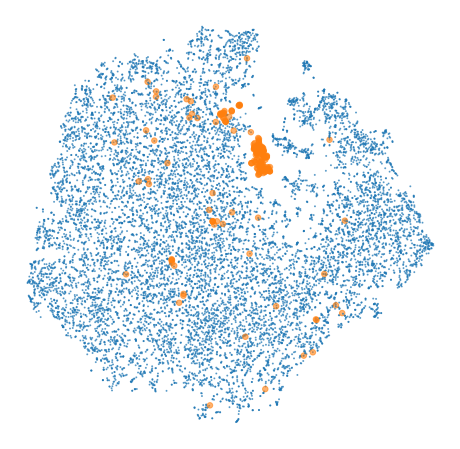

In [31]:
feat_vis = tsne(feat,coords,"/home/xxx/dataset/mil/c16_clam_bio_seg/vis/c_16_lesion_annotation/"+_f+".xml",draw_legend=False)

## AB-MIL

In [32]:
with torch.no_grad():
    feat_fc = attn.feature(torch.tensor(feat))
    pred,a = attn(torch.tensor(feat),return_attn=True)
    print(torch.nn.functional.softmax(pred))
    cam = get_cam_1d(attn.classifier[0],attn.feature(torch.tensor(feat).squeeze(0)),a[0])
    cam = torch.nn.functional.softmax(cam,dim=0)
    cam = cam[1]
    _cam,_cam_idx = torch.sort(cam,descending=True)
    _a,_a_idx = torch.sort(a[0],descending=True)

/tmp/ipykernel_1225287/975969776.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(torch.nn.functional.softmax(pred))


tensor([[7.1796e-04, 9.9928e-01]])


tensor([0.9986, 0.5429, 0.5257,  ..., 0.5000, 0.5000, 0.5000])
tensor([8.8205e-01, 2.2950e-02, 2.1891e-02,  ..., 3.6589e-17, 3.5963e-17,
        3.3968e-17])


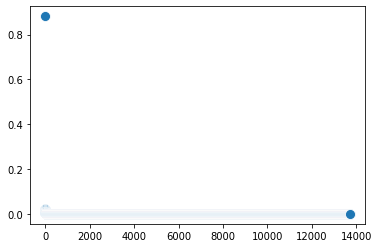

In [33]:
#sns.scatterplot(x=np.array(list(range(_cam.size(0)))),y=_cam)
sns.scatterplot(x=np.array(list(range(_a.size(0)))),y=_a,s=100,alpha=1)
print(_cam)
print(_a)

In [34]:
embedding_attn = TSNE(n_jobs=8).fit(feat_fc.squeeze())

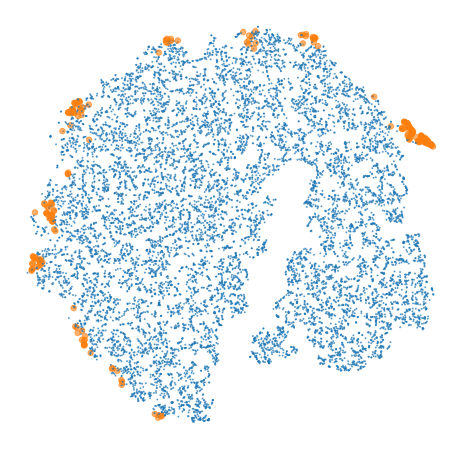

In [36]:
_l = deepcopy(a[0])
_l = (_l - _a[-1]) / (_a[0] - _a[-1])
thr = 0.099999
thr = _a[210]
# _l = deepcopy(cam)
# thr = 0.5001

_l[_l > thr] = 1
_l[_l < thr] = 0

try:
    label = get_label(coords,"/home/xxx/dataset/mil/c16_clam_bio_seg/vis/c_16_lesion_annotation/"+_f+".xml",_l=_l)
except:
    label = None
y = label if label is not None else np.array([1 for i in range(len(embedding_attn))])
attn_vis = plot(embedding_attn,y,draw_legend=False)

## Ntrans

In [37]:
with torch.no_grad():
    feat_fc = ntrans.online_encoder(ntrans.dp(ntrans.patch_to_emb(torch.tensor(feat).squeeze(0))),no_pool=True)

    pred,a = ntrans(torch.tensor(feat),return_attn=True)
    print(torch.nn.functional.softmax(pred))
    cam = get_cam_1d(ntrans.predictor,feat_fc,a[0])
    cam = torch.nn.functional.softmax(cam,dim=0)
    cam = cam[1]
    _cam,_cam_idx = torch.sort(cam,descending=True)
    _a,_a_idx = torch.sort(a[0],descending=True)

tensor([2.5013e-04, 9.9975e-01])


/tmp/ipykernel_1225287/1350638786.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(torch.nn.functional.softmax(pred))


tensor([0.5003, 0.5003, 0.5002,  ..., 0.5001, 0.5001, 0.5000])


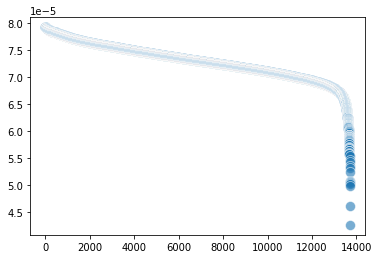

In [38]:
#sns.scatterplot(x=np.array(list(range(_cam.size(0)))),y=_cam)
sns.scatterplot(x=np.array(list(range(_a.size(0)))),y=_a,s=100,alpha=0.6)
print(_cam)

In [39]:
embedding_ntrans = TSNE(n_jobs=8).fit(feat_fc.squeeze())

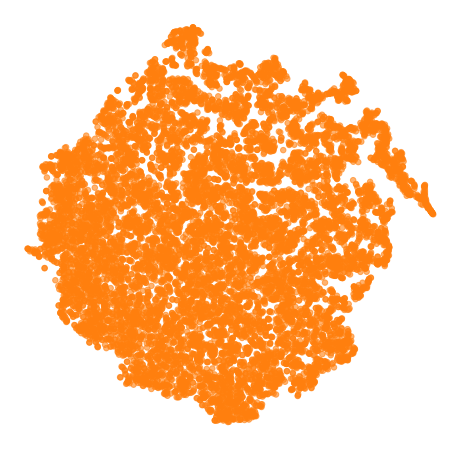

In [40]:
_l = deepcopy(a[0])
_l = (_l - _a[-1]) / (_a[0] - _a[-1])
thr = 0.1
# _l = deepcopy(cam)
# thr = 0.5001

_l[_l > thr] = 1
_l[_l < thr] = 0

try:
    label = get_label(coords,"/home/xxx/dataset/mil/c16_clam_bio_seg/vis/c_16_lesion_annotation/"+_f+".xml",_l)
except:
    label = None
y = label if label is not None else np.array([1 for i in range(len(embedding_ntrans))])
ntrans_vis = plot(embedding_ntrans,y,draw_legend=False)

## RRT

In [41]:
with torch.no_grad():
    feat_fc = _rrt.online_encoder(_rrt.dp(_rrt.patch_to_emb(torch.tensor(feat).squeeze(0))),no_pool=True)

    pred,a = _rrt(torch.tensor(feat),return_attn=True)
    print(torch.nn.functional.softmax(pred))
    cam = get_cam_1d(_rrt.predictor,feat_fc,a[0])
    cam = torch.nn.functional.softmax(cam,dim=0)
    cam = cam[1]
    _cam,_cam_idx = torch.sort(cam,descending=True)
    _a,_a_idx = torch.sort(a[0],descending=True)

tensor([2.7408e-04, 9.9973e-01])


/tmp/ipykernel_1225287/3492627572.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(torch.nn.functional.softmax(pred))


tensor([0.5078, 0.5077, 0.5073,  ..., 0.5000, 0.5000, 0.5000])


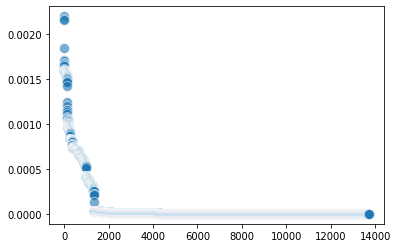

In [42]:
#sns.scatterplot(x=np.array(list(range(_cam.size(0)))),y=_cam)
sns.scatterplot(x=np.array(list(range(_a.size(0)))),y=_a,s=100,alpha=0.6)
print(_cam)

In [43]:
embedding_rrt = TSNE(n_jobs=8).fit(feat_fc.squeeze())

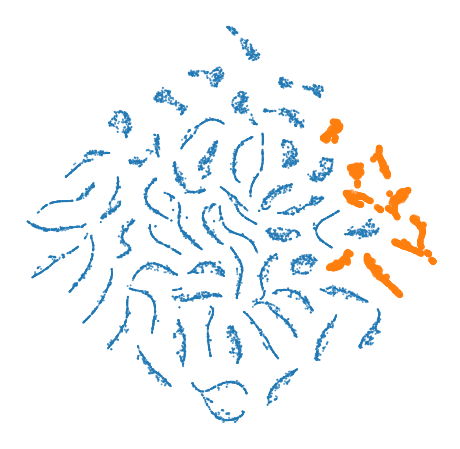

In [44]:
_l = deepcopy(a[0])
_l = (_l - _a[-1]) / (_a[0] - _a[-1])
thr = 0.1
# _l = deepcopy(cam)
# thr = 0.5001

_l[_l > thr] = 1
_l[_l < thr] = 0

try:
    label = get_label(coords,"/home/xxx/dataset/mil/c16_clam_bio_seg/vis/c_16_lesion_annotation/"+_f+".xml",_l)
except:
    label = None
y = label if label is not None else np.array([1 for i in range(len(embedding_rrt))])
rrt_vis = plot(embedding_rrt,y,draw_legend=False)